In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils

from tensorboardX import SummaryWriter

import numpy as np
import random
import matplotlib.pyplot as plt
torch.manual_seed(1)

### Mnist 데이터 셋 

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),])

train_dataset = vdatasets.MNIST(root='./MNIST/',
                               train=True, 
                               transform=transform,
                               download=True)

test_dataset = vdatasets.MNIST(root='./MNIST/',
                               train=False, 
                               transform=transform,
                               download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=64, 
                                           shuffle=True,
                                           num_workers=2)

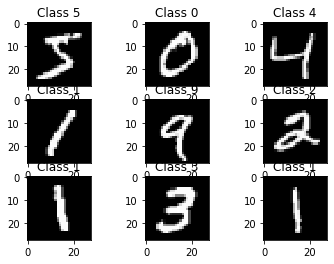

In [3]:
train_dataset[0][0].shape
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].squeeze(0).numpy(), cmap='gray', interpolation='none')
    plt.title("Class {}".format(train_dataset[i][1]))

|   |  |
|:-----------:|:-------:|
|입력 크기|(H, W)|
|필터 크기|(FH, FW)|
|P|padding|
|S|stride|

$$output\_height = \frac{H+2P-FH}{S} + 1$$

$$output\_width = \frac{W+2P-FW}{S}+1$$

In [15]:
class CNet(nn.Module):

    def __init__(self):
        super(CNet, self).__init__()
        
        self.l1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2, stride=1), # 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2) # 16x14x14
        )
        self.l2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, padding=2), # 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2) # 32x7x7
        )
        self.fc = nn.Sequential(
            nn.Linear(32*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10),
        )
        
    def forward(self, x):
        output = self.l1(x)
        output = self.l2(output)
        output = self.fc(output.view(-1, 32*7*7))
        return output

model = CNet()
print(model)

CNet(
  (l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)


In [16]:
# 텐서보드
writer = SummaryWriter(comment="-CNN_LAST")

### Train

In [17]:
EPOCH=5
LR=1e-3

model = CNet()
loss_function = nn.CrossEntropyLoss() ## Softmax 함수가 내장되어 있음.
optimizer = optim.Adam(model.parameters(), lr=LR)

total_Iter = 0

for epoch in range(EPOCH):
    losses = []
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs, targets
        model.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        total_Iter += 1
        if total_Iter % 10 == 0:
            writer.add_scalar('runs/loss_cnn', loss.item(), total_Iter)
            
    print("[%d/%d] mean_loss : %.3f" % (epoch+1,EPOCH, np.mean(losses)))
    
writer.close()

[1/5] mean_loss : 0.328
[2/5] mean_loss : 0.078
[3/5] mean_loss : 0.057
[4/5] mean_loss : 0.042
[5/5] mean_loss : 0.032


### TEST

In [18]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += 64
        correct += (predicted == labels).sum()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 98 %


### Random pick TEST

In [19]:
r = random.randint(0, len(test_dataset)-1)
X_single_data = test_dataset.data[r:r + 1].float()
Y_single_data = test_dataset.targets[r:r + 1]

Label :  [5]
Prediction :  [5]


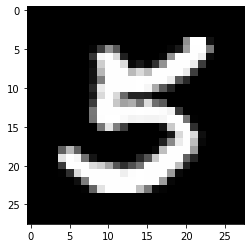

In [20]:
with torch.no_grad():
    single_prediction = model(X_single_data.unsqueeze(1))
    plt.imshow(X_single_data.data.view(28,28).numpy(), cmap='gray')

    print('Label : ', Y_single_data.data.view(1).numpy())
    print('Prediction : ', torch.max(single_prediction.data, 1)[1].numpy())